# CIFAR10 Classification


## The CIFAR10 Dataset

**CIFAR-10** is a widely-used dataset in machine learning, consisting of 60,000 color images across 10 different classes. The dataset is split into 50,000 training images and 10,000 test images, with each image having three color channels (RGB) and a size of $32 \times 32$ pixels.

A few examples of the images from the CIFAR10 dataset:

<center>
    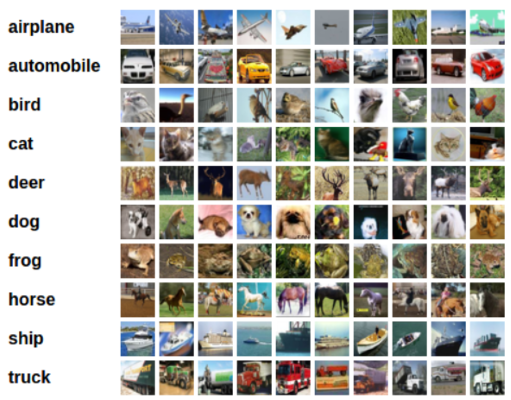
</center>

In [1]:
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl

In [2]:
from torchvision import transforms as tf
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch import Tensor
from PIL import Image

import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torchvision
import torch

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Set seed for reproducibility 

In [4]:
pl.seed_everything(42)

Seed set to 42


42

In [5]:
cifar10 = CIFAR10(root='data', train=True, download=True)

Files already downloaded and verified


# Computing the Dataset statistics 

In [6]:
MEAN = (cifar10.data / 255.0).mean(axis=(0, 1, 2))
STD  = (cifar10.data / 255.0).std( axis=(0, 1, 2))
MEAN, STD

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

# Creating the PyTorch DataLoaders

## Datasets 

In [7]:
transforms_train = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.ToTensor(),
    tf.Normalize(MEAN, STD)
])

trainsforms_test = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(MEAN, STD)
])

train_dataset = CIFAR10(root='data', train=True,  download=True, transform=transforms_train)
test_dataset  = CIFAR10(root='data', train=False, download=True, transform=trainsforms_test)

Files already downloaded and verified
Files already downloaded and verified


## DataLoaders  

In [8]:
batch_size = 128

dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dl_test  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

## Checking batch statistics
To check that normalization works, we can sample a batch and print out the mean and standard deviation (for that batch). The mean should be close to 0 and the standard deviation should be close to 1. 

In [9]:
images, _ = next(iter(dl_train))
print("Batch mean", images.mean(dim=[0, 2, 3]))
print("Batch std ", images.std(dim=[0, 2, 3]))
images.shape

Batch mean tensor([-0.0226,  0.0120,  0.0127])
Batch std  tensor([0.9632, 0.9771, 0.9715])


torch.Size([128, 3, 32, 32])

# Data visualization

Finally, let's check that loading the data worked as expected. 

In [10]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

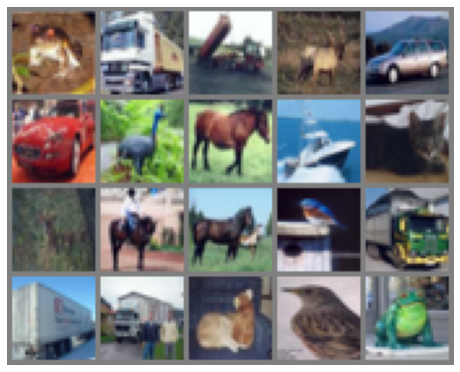

In [11]:
images = [train_dataset[idx][0] for idx in range(20)]
image_grid = make_grid(images, nrow=5, normalize=True, pad_value=0.5).permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(image_grid)
plt.axis('off')
plt.show()

## Defining the network architecture 

In [12]:
class SimpleCNN(nn.Module):
    
    def __init__(self, in_channels: int = 3, n_classes: int = 10) -> None:
        super(SimpleCNN, self).__init__()
        
        ### TODO 1: Define network architecture ###
        
        # self.conv1 = nn.Conv2d(?, ?, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(?, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # self.fc1 = nn.Linear(?, ?)
        # self.fc2 = nn.Linear(512, ?)
        
        self.relu = nn.ReLU()
        
        self.features = [
            self.conv1, self.relu, self.pool,
            self.conv2, self.relu, self.pool,
            self.conv3, self.relu, self.pool
        ]
        
    def forward(self, x):
        
        ### TODO 2: Implement the forward pass ###
        # x -> conv1 -> relu -> pool -> conv2 -> relu -> pool -> 
        #   -> conv3 -> relu -> pool -> flatten -> fc1 -> relu -> fc2 -> output

        # You can use x.view(x.size(0), -1) or torch.flatten(x, 1) to flatten the tensor

        return x

In [13]:
x = torch.randn(8, 3, 32, 32)
model = SimpleCNN()

# Running a batch of 8 images should produce 8 probability distributions
model(x).shape  # output should be of shape [8, 10]

torch.Size([8, 10])

## Constructing the Lightning Module 

In [14]:
class CIFAR10Module(pl.LightningModule):
    
    def __init__(self, model: nn.Module, lr: float = 1e-3):
        super().__init__()
        self.model = model
    
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        
    def forward(self, images):
        return model(images)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)        
        return [optimizer]
    
    def step(self, batch, mode):
        
        images, labels = batch
        
        ### TODO 3: Define the forward pass ###
        
        # Get the model output 
        # preds = ...
        
        # Compute the loss
        # loss = ...
        
        # Compute accuracy metric for tracking model performance
        # accuracy = ...

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log(f'{mode}_acc', accuracy, on_step=False, on_epoch=True)
        self.log(f'{mode}_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def training_step(self, batch, batch_idx):
        return self.step(batch, mode='train')
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, mode='val')

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        accuracy = (preds.argmax(dim=-1) == labels).float().mean()
        self.log('test_acc', accuracy)

In [15]:
model = SimpleCNN()
module = CIFAR10Module(model)

In [16]:
trainer = pl.Trainer(
    default_root_dir='models/cnn_cifar10',
    accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
    max_epochs=10,
    enable_checkpointing=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Training and saving just the network weights

In [17]:
# %load_ext tensorboard
# %tensorboard --logdir=models/cnn_cifar10

In [18]:
# %%time 
# trainer.fit(module, dl_train, dl_test)  # 3min 43s
# torch.save(module.model.state_dict(), 'models/cnn_cifar10/trained_cnn.pth')

# Helpers for visualization  

In [19]:
def get_activations(model: nn.Module, image: Tensor) -> list[Tensor]:
    """Construct a list of activations at each layer in the network"""
    activations = []
    x = image

    for layer in model.features:
        x = layer(x)
        activations.append(x)
        
    return activations

In [20]:
def denorm(x: Tensor) -> Tensor:
    """Undo the normalization and return the reconstructed Tensor to its original domain"""
    print(x.shape)
    return x * STD[..., None, None] + MEAN[..., None, None]

In [21]:
def plot_image(image: Tensor) -> None:
    
    if len(image.shape) == 4:
        image = image[0]

    image = denorm(image)  # Convert to [0, 1] range
    
    image = image.cpu().permute(1, 2, 0).numpy()
    image = np.clip(image, 0., 1.)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [22]:
def to_grayscale(x: np.ndarray) -> np.ndarray:
    """Normalize feature map to [0, 1]"""
    if x.min() == x.max():
        return np.zeros_like(x)
    
    return (x - x.min()) / (x.max() - x.min())

In [23]:
def plot_activations(title: str, activations: Tensor, 
                     n_cols: int, figsize: tuple[int, int] = (14, 7)) -> None:
    _, c, h, w = activations.shape
    
    n_rows = c // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.9)
    fig.suptitle(title, fontsize=18, y=1 if n_rows != 8 else 0.95)
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[j] if n_rows == 1 else axes[i][j]
            
            feature_map = activations[0, i * n_rows + j].detach().cpu().numpy()
            feature_map = to_grayscale(feature_map)
            ax.imshow(feature_map, cmap='magma')
            ax.axis('off')
            
    plt.show()

In [24]:
def plot_filters(title: str, weights: Tensor, n_cols: int, figsize: tuple[int, int]) -> None:
    f_out, f_in, k_h, k_w = weights.shape
    
    n_rows = f_out // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.05, hspace=0.07)
    fig.suptitle(title, fontsize=18, y=0.95)
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[j] if n_rows == 1 else axes[i][j]
            
            conv_filter = weights[i * n_rows + j]
            conv_filter = conv_filter.mean(dim=0, keepdim=True).permute(1, 2, 0)
            conv_filter = conv_filter.detach().cpu().numpy()
            conv_filter = to_grayscale(conv_filter)
            ax.imshow(conv_filter, cmap='viridis')
            ax.axis('off')
            
    plt.show()

# Loading the trained model 

In [25]:
model = SimpleCNN()
model.load_state_dict(torch.load('models/cnn_cifar10/trained_cnn.pth'))

<All keys matched successfully>

# Sampling an image from the Test set 

In [26]:
images, labels = next(iter(dl_test))

torch.Size([3, 32, 32])


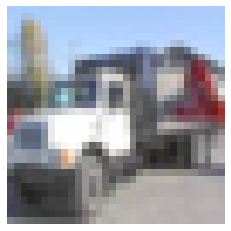

In [27]:
image = images[45, ...][None]; image.shape
plot_image(image)

## Plotting the output distribution for the current sample 

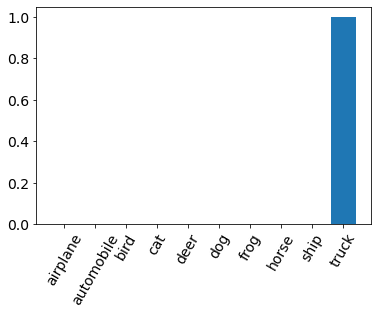

In [28]:
preds = model(image)
probs = F.softmax(preds, dim=-1)[0].detach().cpu().numpy()

plt.bar(range(10), probs)
plt.xticks(range(10), test_dataset.classes, rotation=60, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Getting the activations for the sampled Image 

In [29]:
activations = get_activations(model, image)
for act in activations:
    print(act.shape)

torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 4, 4])


# Feature Maps

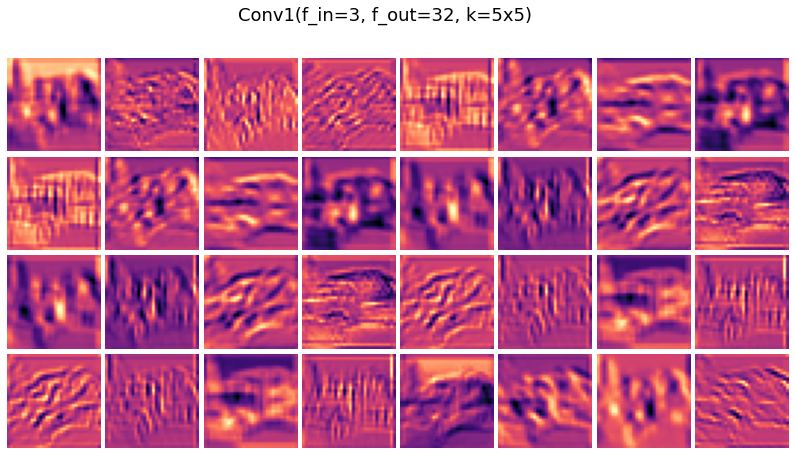

In [30]:
plot_activations('Conv1(f_in=3, f_out=32, k=5x5)', activations[0], 8, figsize=(14, 7))

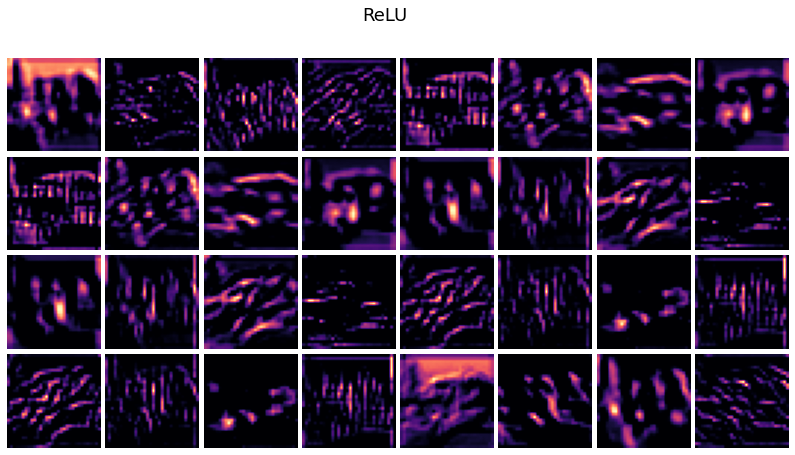

In [31]:
plot_activations('ReLU', activations[1], 8, figsize=(14, 7))

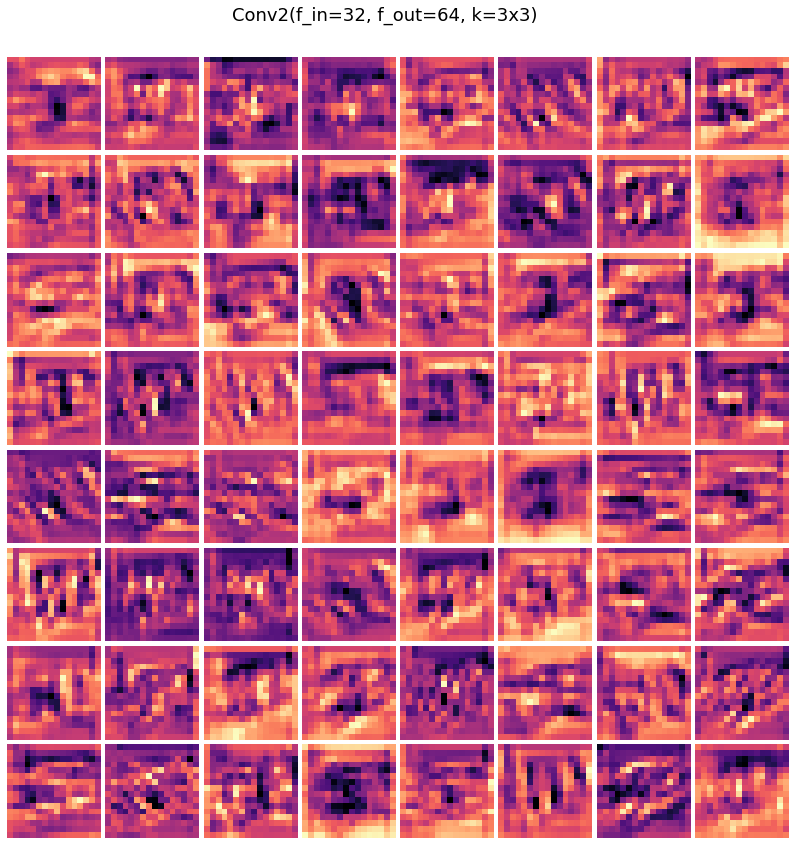

In [32]:
plot_activations('Conv2(f_in=32, f_out=64, k=3x3)', activations[3], 8, figsize=(14, 14))

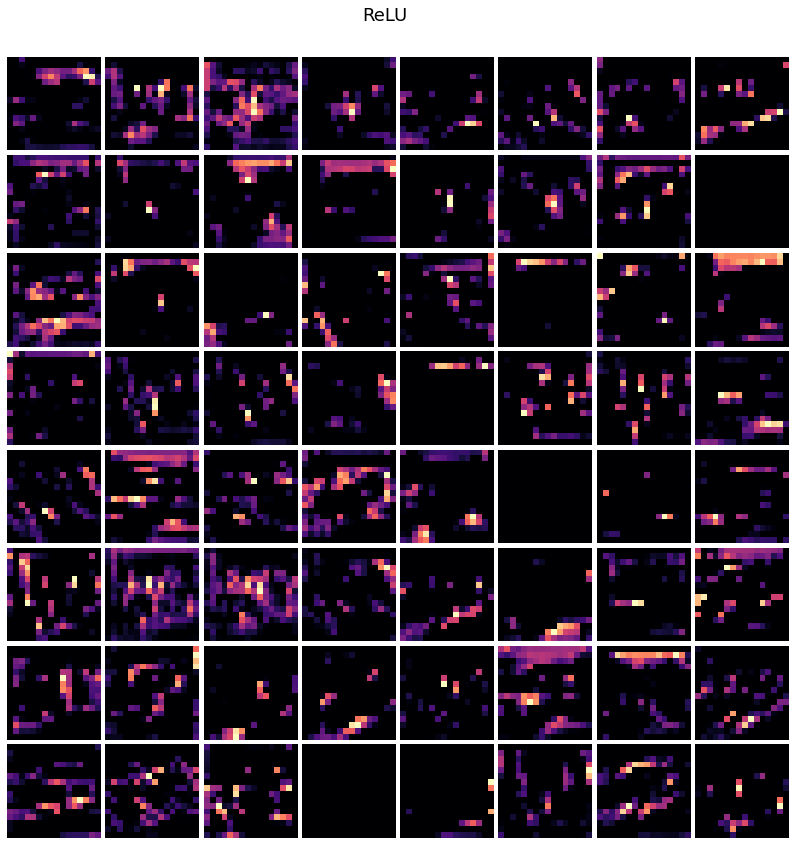

In [33]:
plot_activations('ReLU', activations[4], 8, figsize=(14, 14))

# Conv Weights 

In [34]:
model.conv1.weight.shape

torch.Size([32, 3, 5, 5])

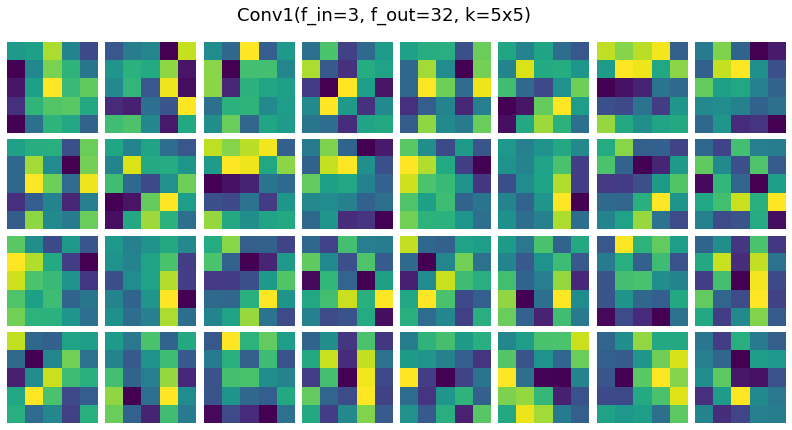

In [35]:
plot_filters('Conv1(f_in=3, f_out=32, k=5x5)', model.conv1.weight, 8, figsize=(14, 7))

<br><br><br>

# How about for a random initialization 

In [36]:
model = SimpleCNN()
activations = get_activations(model, image)

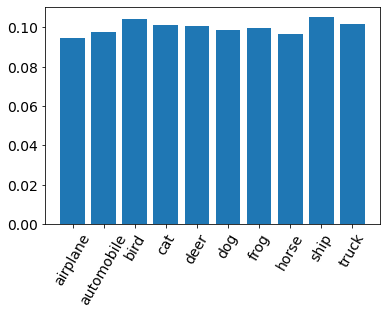

In [37]:
preds = model(image)
probs = F.softmax(preds, dim=-1)[0].detach().cpu().numpy()

plt.bar(range(10), probs)
plt.xticks(range(10), test_dataset.classes, rotation=60, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

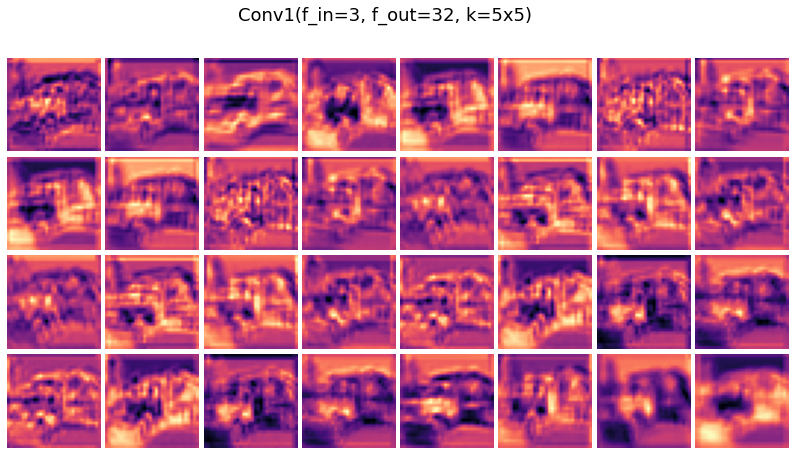

In [38]:
plot_activations('Conv1(f_in=3, f_out=32, k=5x5)', activations[0], 8, figsize=(14, 7))

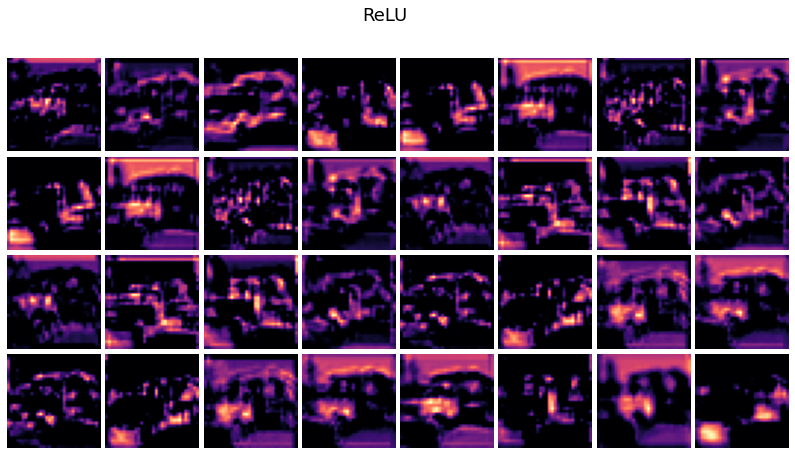

In [39]:
plot_activations('ReLU', activations[1], 8, figsize=(14, 7))

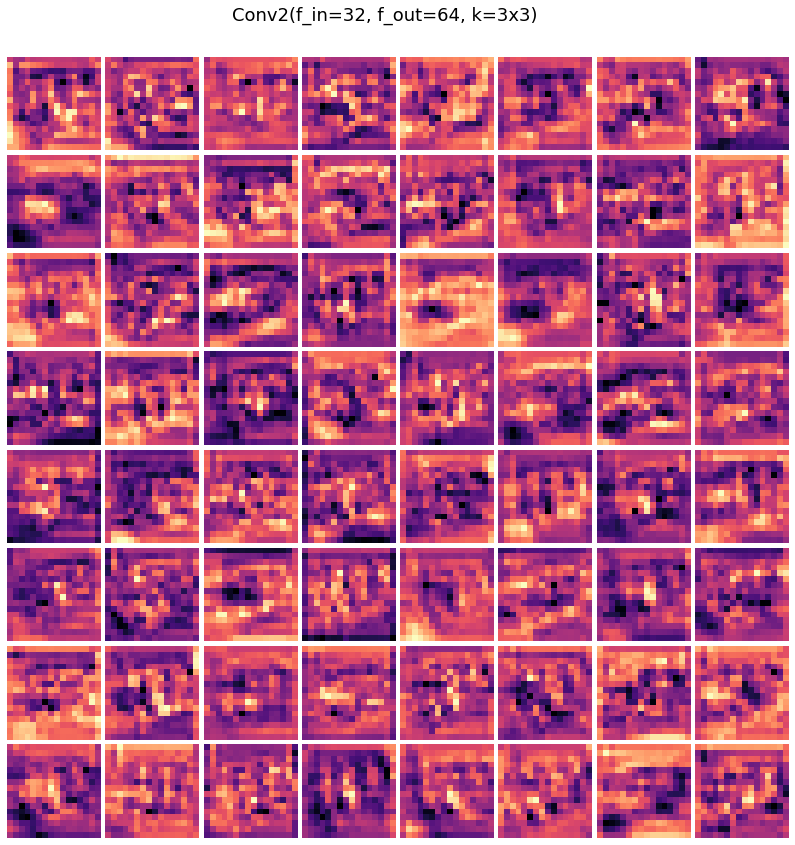

In [40]:
plot_activations('Conv2(f_in=32, f_out=64, k=3x3)', activations[3], 8, figsize=(14, 14))

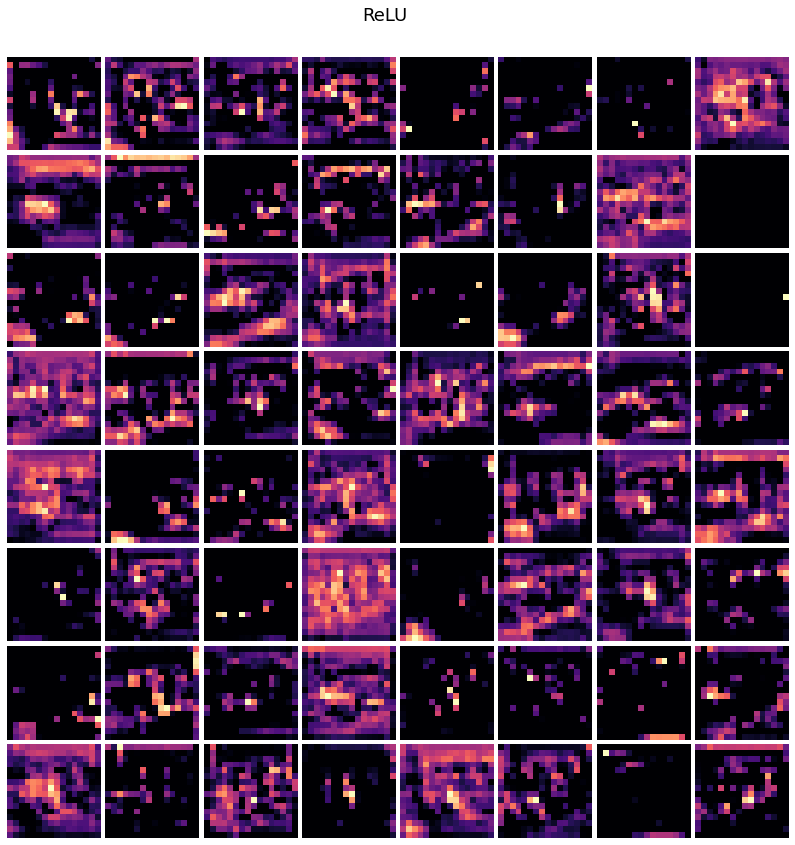

In [41]:
plot_activations('ReLU', activations[4], 8, figsize=(14, 14))

# Conv Weights 

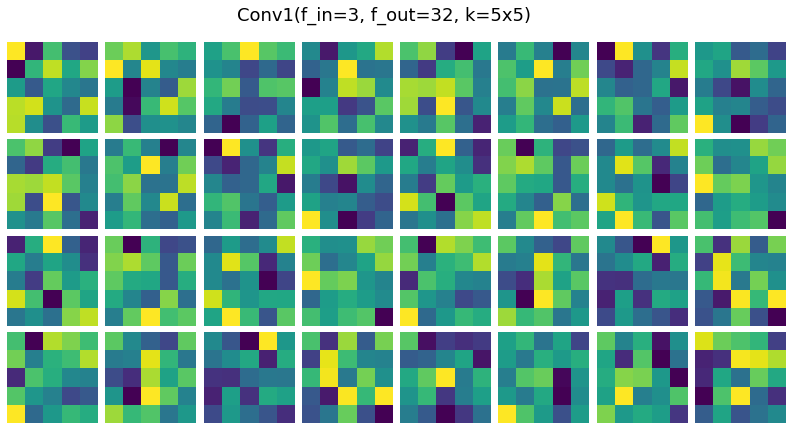

In [42]:
plot_filters('Conv1(f_in=3, f_out=32, k=5x5)', model.conv1.weight, 8, figsize=(14, 7))

<br><br>

# About word about visualizing and understanding CNNs 

<center>
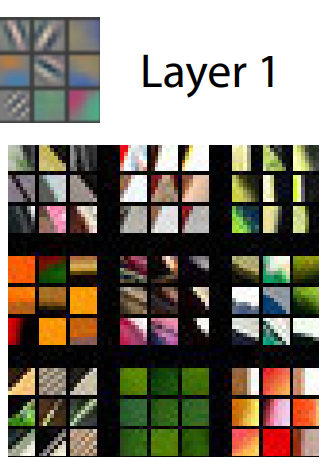
</center>

<center>
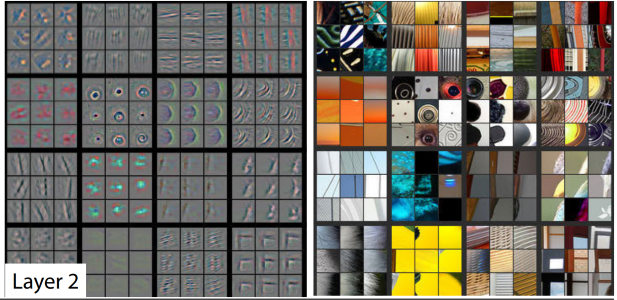
</center>

<center>
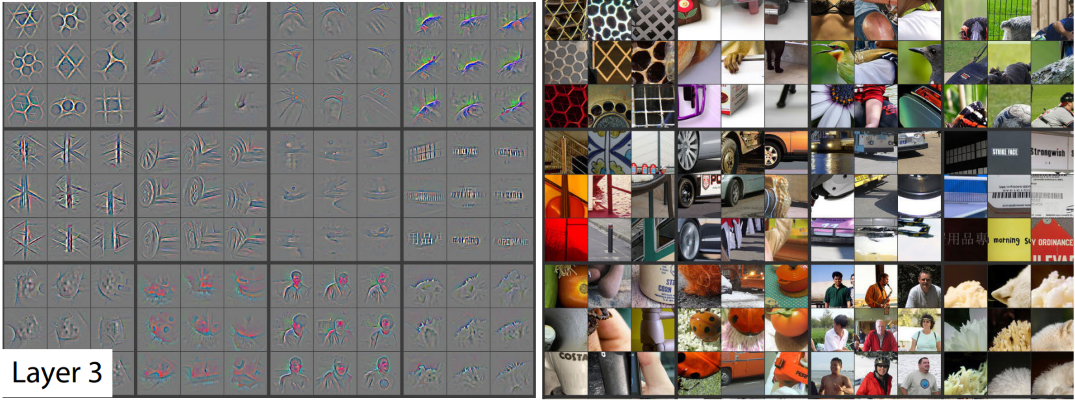
</center>

Source: [Zeiler & Fergus, Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901) 